In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

C:\Users\danie\AppData\Local\Temp\ipykernel_17100\873636676.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
with engine.connect() as conn:
    result = conn.execute(text('SELECT max(date) FROM Measurement'))
    for record in result:
        last_date=record[0]
        print(last_date)

2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date_2 = datetime.strptime(last_date, '%Y-%m-%d').date()
print(last_date_2)

2017-08-23


In [11]:
# Calculate the date one year from the last date in data set.
previous_date=last_date_2-timedelta(days=365)
print(previous_date)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= previous_date).\
    filter(Measurement.date <= last_date_2).all()
precipitation_data

# Convert the list into a dictionary
result_dicts = [{column.name: getattr(row, column.name) 
for column in (Measurement.date,Measurement.prcp)} for row in precipitation_data]
result_dicts

[{'date': '2016-08-23', 'prcp': 0.0},
 {'date': '2016-08-24', 'prcp': 0.08},
 {'date': '2016-08-25', 'prcp': 0.08},
 {'date': '2016-08-26', 'prcp': 0.0},
 {'date': '2016-08-27', 'prcp': 0.0},
 {'date': '2016-08-28', 'prcp': 0.01},
 {'date': '2016-08-29', 'prcp': 0.0},
 {'date': '2016-08-30', 'prcp': 0.0},
 {'date': '2016-08-31', 'prcp': 0.13},
 {'date': '2016-09-01', 'prcp': 0.0},
 {'date': '2016-09-02', 'prcp': 0.0},
 {'date': '2016-09-03', 'prcp': 0.0},
 {'date': '2016-09-04', 'prcp': 0.03},
 {'date': '2016-09-05', 'prcp': None},
 {'date': '2016-09-06', 'prcp': None},
 {'date': '2016-09-07', 'prcp': 0.05},
 {'date': '2016-09-08', 'prcp': 0.0},
 {'date': '2016-09-09', 'prcp': 0.03},
 {'date': '2016-09-10', 'prcp': 0.0},
 {'date': '2016-09-11', 'prcp': 0.05},
 {'date': '2016-09-12', 'prcp': 0.0},
 {'date': '2016-09-13', 'prcp': 0.02},
 {'date': '2016-09-14', 'prcp': 1.32},
 {'date': '2016-09-15', 'prcp': 0.42},
 {'date': '2016-09-16', 'prcp': 0.06},
 {'date': '2016-09-17', 'prcp': 0.05

In [13]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df=pd.DataFrame(precipitation_data).rename(columns={'date': 'Date', 'prcp': 'Precipitation'})
precipitation_df

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [14]:
# Sort the dataframe by date
precipitation_df=precipitation_df.sort_values('Date',ascending=True).dropna()
precipitation_df

,Date,Precipitation
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


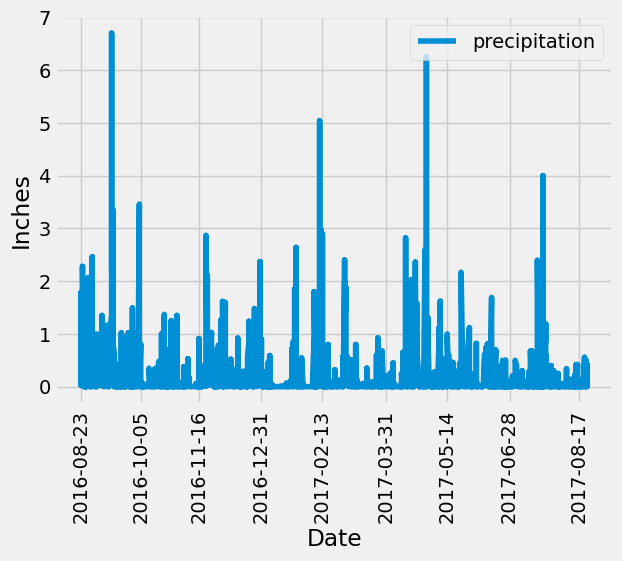

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(precipitation_df['Date'],precipitation_df['Precipitation'])
ticks = plt.xticks(precipitation_df['Date'][::250],rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(['precipitation'],loc='upper right')
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats_df=pd.DataFrame(precipitation_df['Precipitation'].describe())
sum_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(Station.station).count()
station_count

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_data=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_analysis=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_data[0][0]).all()
temperature_analysis

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).filter(Measurement.date >= previous_date).\
    filter(Measurement.date <= last_date_2).\
    filter(Measurement.station==station_data[0][0]).all()
temp_data

temp_data_df=pd.DataFrame(temp_data)
temp_data_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


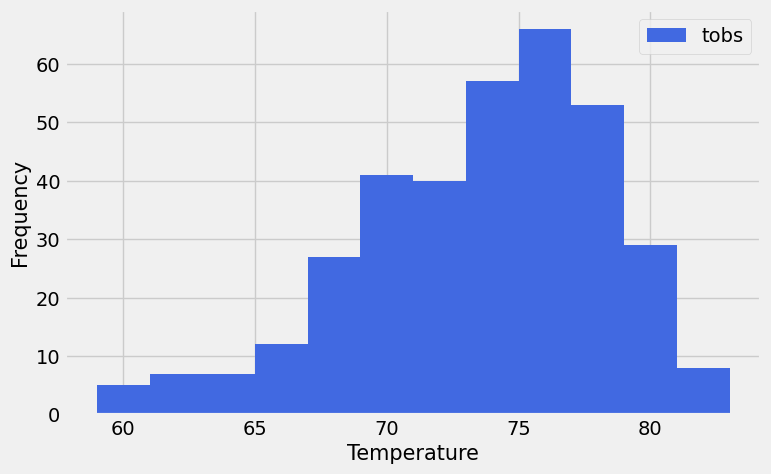

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist = temp_data_df['tobs'].hist(bins=12,figsize=(8,5), color='royalblue', zorder=2)
hist.set_xlabel("Temperature", size=15)
hist.set_ylabel("Frequency", size=15)
hist.legend(['tobs'],loc='upper right')
plt.show()

# Close Session

In [23]:
# Close Session
session.close()